In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [4]:
from matplotlib import pyplot as plt
print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb('/content/drive/MyDrive/Colab Notebooks/Train 60000.cdb')
print('Train Dataset Loaded')
print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb('/content/drive/MyDrive/Colab Notebooks/Test 20000.cdb')
print('Test Dataset Loaded')

Reading Train 60000.cdb ...
Train Dataset Loaded
Reading Test 20000.cdb ...
Test Dataset Loaded


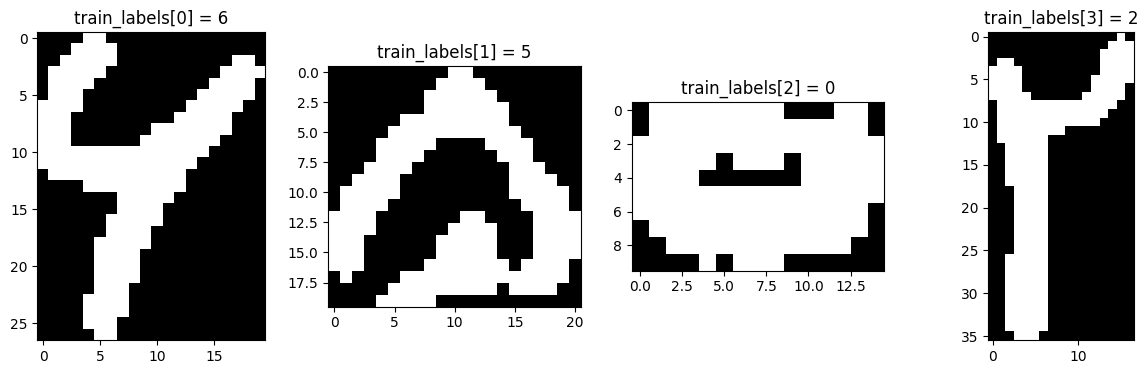

In [5]:
fig = plt.figure(figsize=(15, 4))
for i in range(4):

    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(train_labels[i]))
    plt.imshow(train_images[i], cmap='gray')

plt.show()


In [6]:
import random
train_images_subset = train_images[:3000]
train_labels_subset = train_labels[:3000]
# Select 1000 elements randomly from test_images
selected_indices = random.sample(range(len(test_images)), 1000)
print(selected_indices)
# Use the selected indices to get corresponding images and labels
test_images_subset = [test_images[i] for i in selected_indices]
test_labels_subset = [test_labels[i] for i in selected_indices]


[13490, 11727, 10474, 4250, 402, 9479, 6788, 13480, 5183, 4971, 1618, 14178, 2824, 7166, 15377, 11369, 13438, 18710, 19861, 9146, 1147, 14436, 8119, 4541, 9001, 6761, 1872, 19937, 16636, 11207, 13088, 207, 19203, 16850, 19405, 12013, 4207, 2391, 1930, 8042, 18491, 7120, 13280, 16455, 10919, 7751, 8670, 4021, 78, 18851, 13624, 14134, 7805, 11558, 19005, 15192, 4914, 1966, 17861, 12476, 14018, 11790, 10179, 1483, 13740, 2192, 2721, 5605, 5100, 10866, 12011, 3748, 2413, 14386, 10640, 16871, 9627, 10618, 4676, 11004, 17828, 4531, 2259, 5457, 294, 3957, 6114, 14264, 3678, 8753, 15087, 17545, 18330, 8995, 9383, 1114, 816, 9967, 19560, 7701, 4033, 10463, 4619, 6225, 17698, 6992, 4112, 8915, 14987, 889, 1563, 4299, 80, 15000, 8585, 12228, 13723, 14706, 8424, 5604, 6858, 12179, 6115, 11984, 12998, 1845, 15164, 11327, 1735, 8634, 923, 2490, 8188, 4896, 12834, 18760, 894, 19765, 10070, 12608, 9509, 9229, 4449, 5327, 13652, 12400, 8081, 656, 14420, 786, 10419, 848, 14642, 5506, 12387, 10928, 14885

In [7]:
# Initialize dimensions
max_width, max_width_index = max((img.shape[0], i) for i, img in enumerate(train_images_subset + test_images_subset))
max_length, max_length_index = max((img.shape[1], i) for i, img in enumerate(train_images_subset + test_images_subset))
# Initialize the 3D train matrix
num_images = len(train_images_subset)
matrix_3d_train = np.zeros((num_images, max_width, max_length))
# Initialize the 3D test matrix
num_images1 = len(test_images_subset)
matrix_3d_test = np.zeros((num_images1, max_width, max_length))

In [8]:
# Fill the matrix with image data, centering each image
for i, img in enumerate(train_images_subset):
    start_row = (max_width - img.shape[0]) // 2
    start_col = (max_length - img.shape[1]) // 2
    end_row = start_row + img.shape[0]
    end_col = start_col + img.shape[1]
    matrix_3d_train[i, start_row:end_row, start_col:end_col] = img

# Now, matrix_3d is filled with image data, and each image is centered in its corresponding matrix
for i, img in enumerate(test_images_subset):
    start_row = (max_width - img.shape[0]) // 2
    start_col = (max_length - img.shape[1]) // 2
    end_row = start_row + img.shape[0]
    end_col = start_col + img.shape[1]
    matrix_3d_test[i, start_row:end_row, start_col:end_col] = img

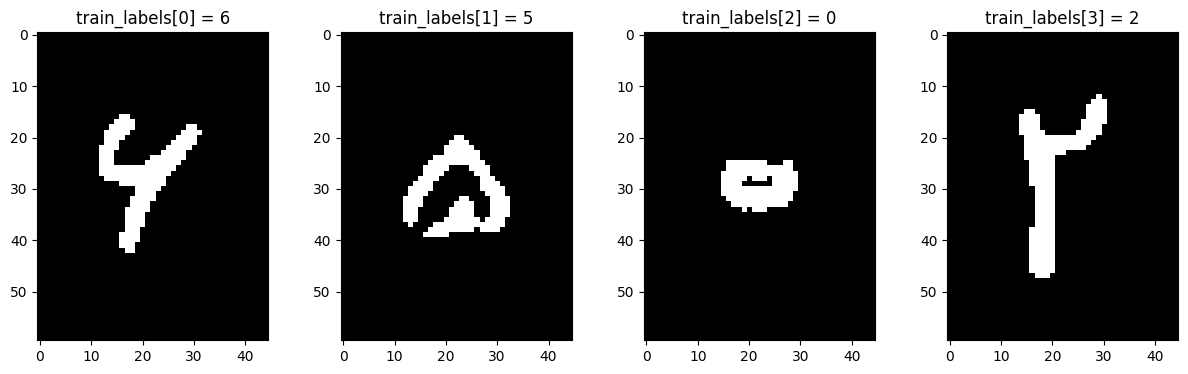

In [9]:
# Plot the first 4 images of matrix_3d
fig = plt.figure(figsize=(15, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(train_labels_subset[i]))
    plt.imshow(matrix_3d_train[i], cmap='gray')

plt.show()

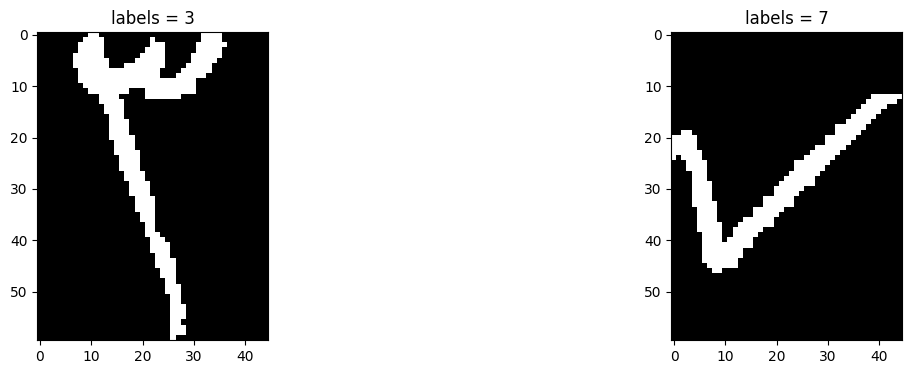

In [10]:
# Plot 2 images of matrix_3d which give us the max_width and max_length
fig = plt.figure(figsize=(15, 4))
fig.add_subplot(1, 2, 1)
plt.title('labels = ' + str((train_labels_subset+test_labels_subset)[max_width_index]))
plt.imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.title('labels = ' + str((train_labels_subset+test_labels_subset)[max_length_index]))
plt.imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_length_index], cmap='gray')

plt.show()

In [11]:
# Calculate horizontal and vertical histograms for all images
horizontal_histograms_train = np.sum(matrix_3d_train, axis=1)
vertical_histograms_train = np.sum(matrix_3d_train, axis=2)
# Now, horizontal_histograms and vertical_histograms contain the histograms for all images
# Each row in these arrays corresponds to an image in train_images_subset
# Calculate horizontal and vertical histograms for all images
horizontal_histograms_test = np.sum(matrix_3d_test, axis=1)
vertical_histograms_test = np.sum(matrix_3d_test, axis=2)
# Now, horizontal_histograms and vertical_histograms contain the histograms for all images
# Each row in these arrays corresponds to an image in train_images_subset

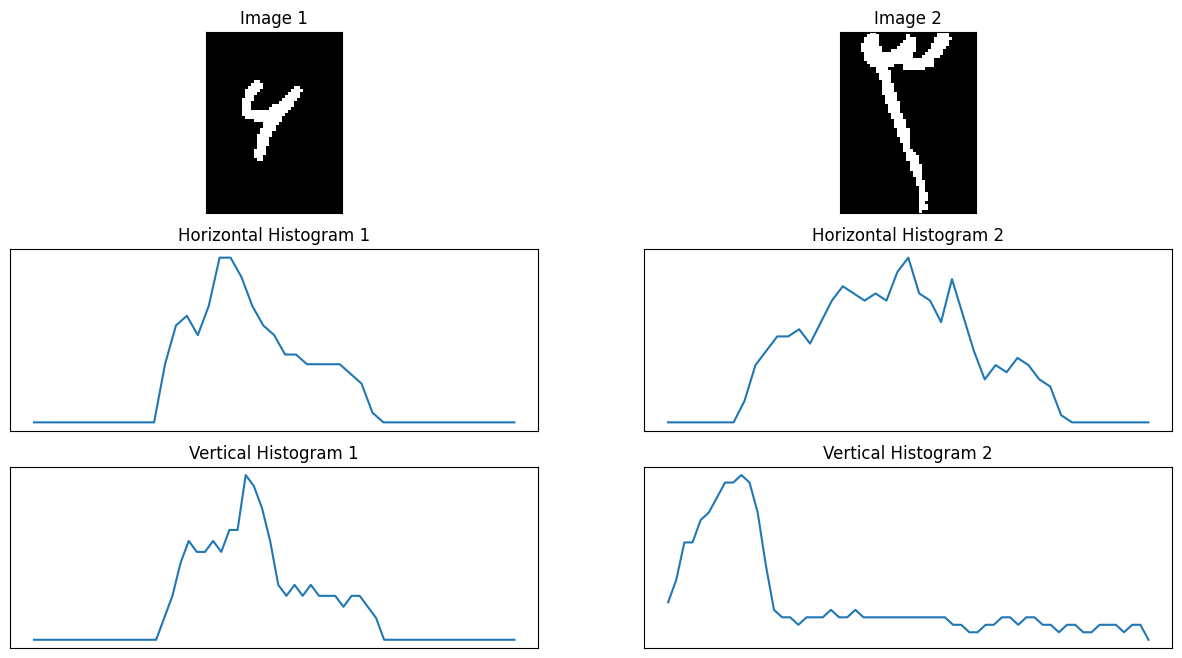

In [12]:
# Plot the horizontal and vertical histograms along with 2 images

fig, axes = plt.subplots(3, 2, figsize=(15, 8))

# Plot the first image
axes[0, 0].imshow(matrix_3d_train[0], cmap='gray')
axes[0, 0].set_title('Image 1')
axes[0, 0].set_xticks([])  # Hide x-axis ticks
axes[0, 0].set_yticks([])  # Hide y-axis ticks

# Plot the horizontal histogram for the first image
axes[1, 0].plot(horizontal_histograms_train[0])
axes[1, 0].set_title('Horizontal Histogram 1')
axes[1, 0].set_xticks([])  # Hide x-axis ticks
axes[1, 0].set_yticks([])  # Hide y-axis ticks

# Plot the vertical histogram for the first image
axes[2, 0].plot(vertical_histograms_train[0])
axes[2, 0].set_title('Vertical Histogram 1')
axes[2, 0].set_xticks([])  # Hide x-axis ticks
axes[2, 0].set_yticks([])  # Hide y-axis ticks

# Plot the second image
axes[0, 1].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
axes[0, 1].set_title('Image 2')
axes[0, 1].set_xticks([])  # Hide x-axis ticks
axes[0, 1].set_yticks([])  # Hide y-axis ticks

# Plot the horizontal histogram for the second image
axes[1, 1].plot(np.concatenate((horizontal_histograms_train, horizontal_histograms_test), axis=0)[max_width_index])
axes[1, 1].set_title('Horizontal Histogram 2')
axes[1, 1].set_xticks([])  # Hide x-axis ticks
axes[1, 1].set_yticks([])  # Hide y-axis ticks

# Plot the vertical histogram for the second image
axes[2, 1].plot(np.concatenate((vertical_histograms_train, vertical_histograms_test), axis=0)[max_width_index])
axes[2, 1].set_title('Vertical Histogram 2')
axes[2, 1].set_xticks([])  # Hide x-axis ticks
axes[2, 1].set_yticks([])  # Hide y-axis ticks

plt.show()

In [13]:
def zoning(matrix):
# Initialize dimensions
    num_images, max_width, max_length = matrix.shape

# Calculate zoning feature vectors for all images
    zoning_feature_vectors = []

# Iterate over images
    for img_idx in range(num_images):
        zoning_feature_vector = []

    # Iterate over zones (5x5)
        for i in range(5):
            for j in range(5):
            # Calculate average intensity in the current zone for the current image
                avg_intensity = np.mean(matrix[img_idx,
                                                        i * max_width // 5 : (i + 1) * max_width // 5,
                                                        j * max_length // 5 : (j + 1) * max_length // 5])
                zoning_feature_vector.append(avg_intensity)

        zoning_feature_vectors.append(zoning_feature_vector)
    return zoning_feature_vectors
# Now, zoning_feature_vectors is a list containing the zoning feature vector for each image in matrix
# Each element of the list corresponds to an image
zoning_feature_vectors_train = zoning(matrix_3d_train)
zoning_feature_vectors_test = zoning(matrix_3d_test)
# Reshape zoning feature vectors to 5x5 matrices
zoning_matrices_train = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning(matrix_3d_train)]
zoning_matrices_test = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning(matrix_3d_test)]


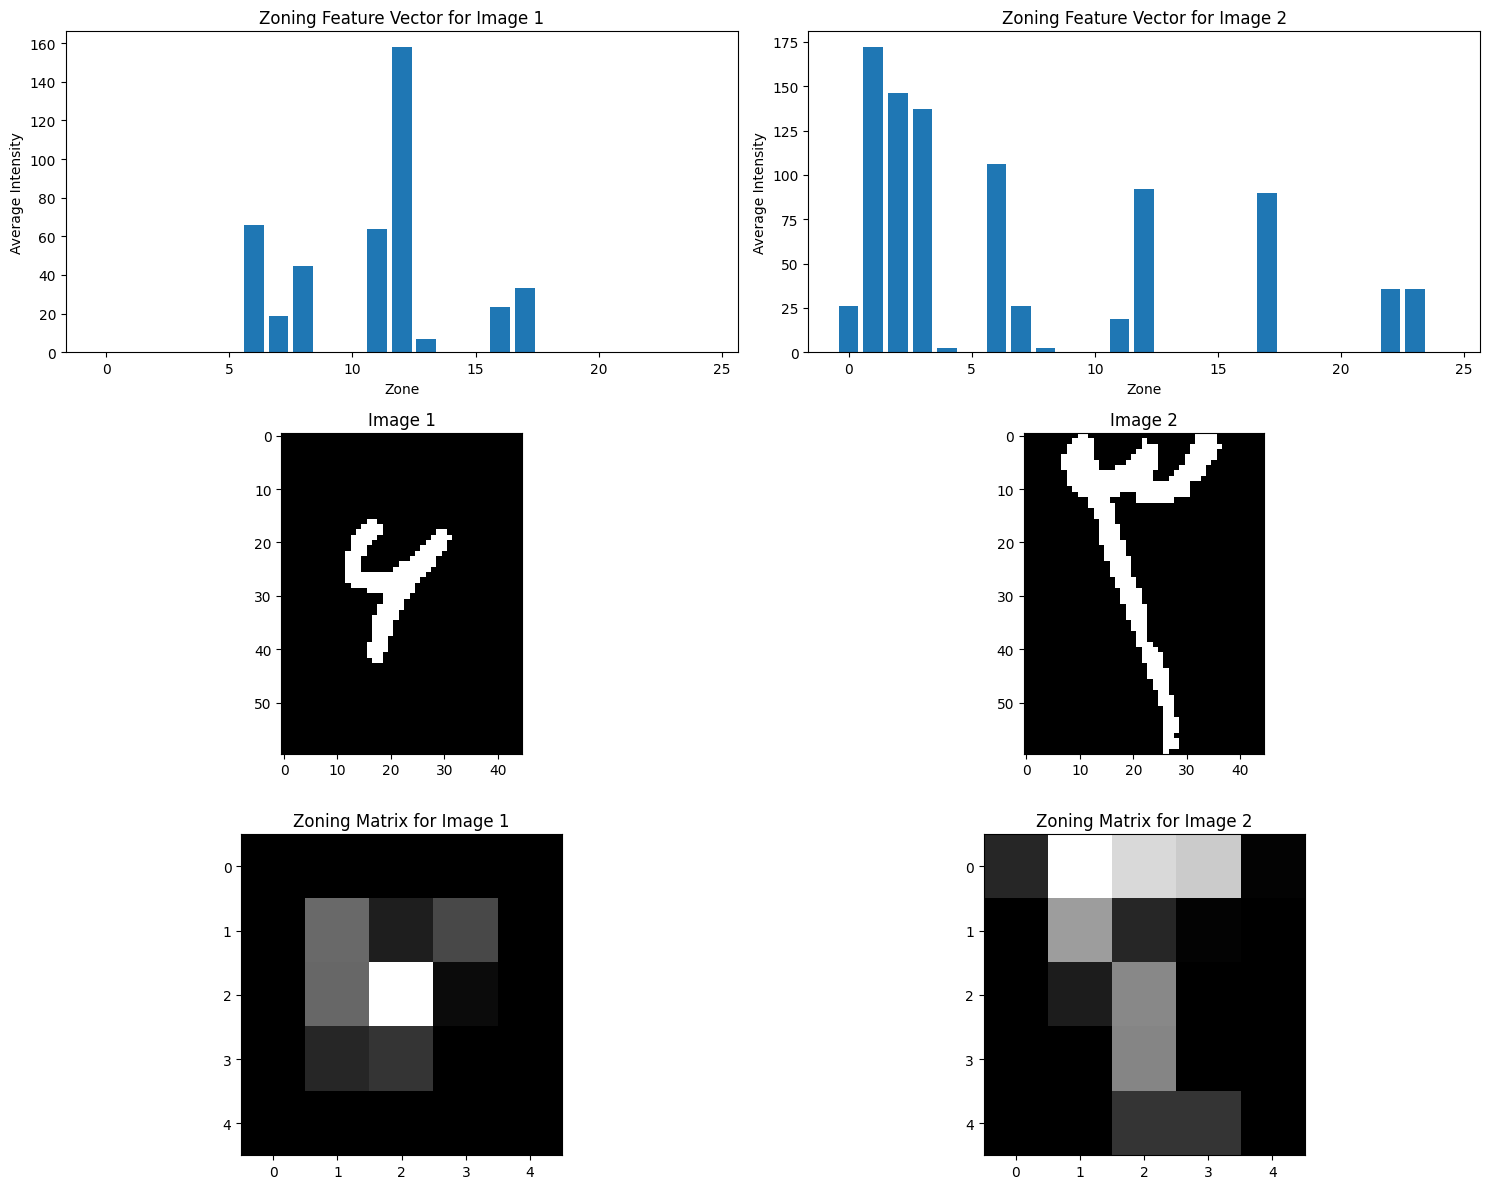

In [14]:

# Plot zoning feature vectors along with the images for the first two images
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot zoning feature vector for the first image
axes[0, 0].bar(range(len(zoning_feature_vectors_train[0])), zoning_feature_vectors_train[0])
axes[0, 0].set_title('Zoning Feature Vector for Image 1')
axes[0, 0].set_xlabel('Zone')
axes[0, 0].set_ylabel('Average Intensity')

# Plot zoning feature vector for the second image
axes[0, 1].bar(range(len((zoning_feature_vectors_train+zoning_feature_vectors_test)[max_width_index])), (zoning_feature_vectors_train+zoning_feature_vectors_test)[max_width_index])
axes[0, 1].set_title('Zoning Feature Vector for Image 2')
axes[0, 1].set_xlabel('Zone')
axes[0, 1].set_ylabel('Average Intensity')

# Plot the first image
axes[1, 0].imshow(matrix_3d_train[0], cmap='gray')
axes[1, 0].set_title('Image 1')

# Plot the second image
axes[1, 1].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
axes[1, 1].set_title('Image 2')

# Plot zoning matrix for the first image
axes[2, 0].imshow(zoning_matrices_train[0], cmap='gray')
axes[2, 0].set_title('Zoning Matrix for Image 1')
# Plot zoning matrix for the second image
axes[2, 1].imshow((zoning_matrices_train+zoning_matrices_test)[max_width_index], cmap='gray')
axes[2, 1].set_title('Zoning Matrix for Image 2')

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
import pywt
from skimage.transform import resize
# Function to resize each image to 64x64
def resize_images(images):
    resized_images = np.zeros((images.shape[0], 64, 64))
    for i in range(images.shape[0]):
        resized_images[i] = resize(images[i], (64, 64), mode='constant', anti_aliasing=True)
    return resized_images

# Function to extract wavelet features
def extract_wavelet_features(image):
    coeffs = pywt.wavedec2(image, 'haar', level=3)
    # Select the approximation coefficients at level 3 (8x8 image)
    features = coeffs[0].ravel()
    return features

# Resize the images
resized_images_train = resize_images(matrix_3d_train)

# Extract wavelet features for each image
wavelet_features_train = np.array([extract_wavelet_features(img) for img in resized_images_train])
# wavelet_features now contains the desired features for each image
# Its shape should be (3000, 64)
# Resize the images
resized_images_test = resize_images(matrix_3d_test)

# Extract wavelet features for each image
wavelet_features_test = np.array([extract_wavelet_features(img) for img in resized_images_test])

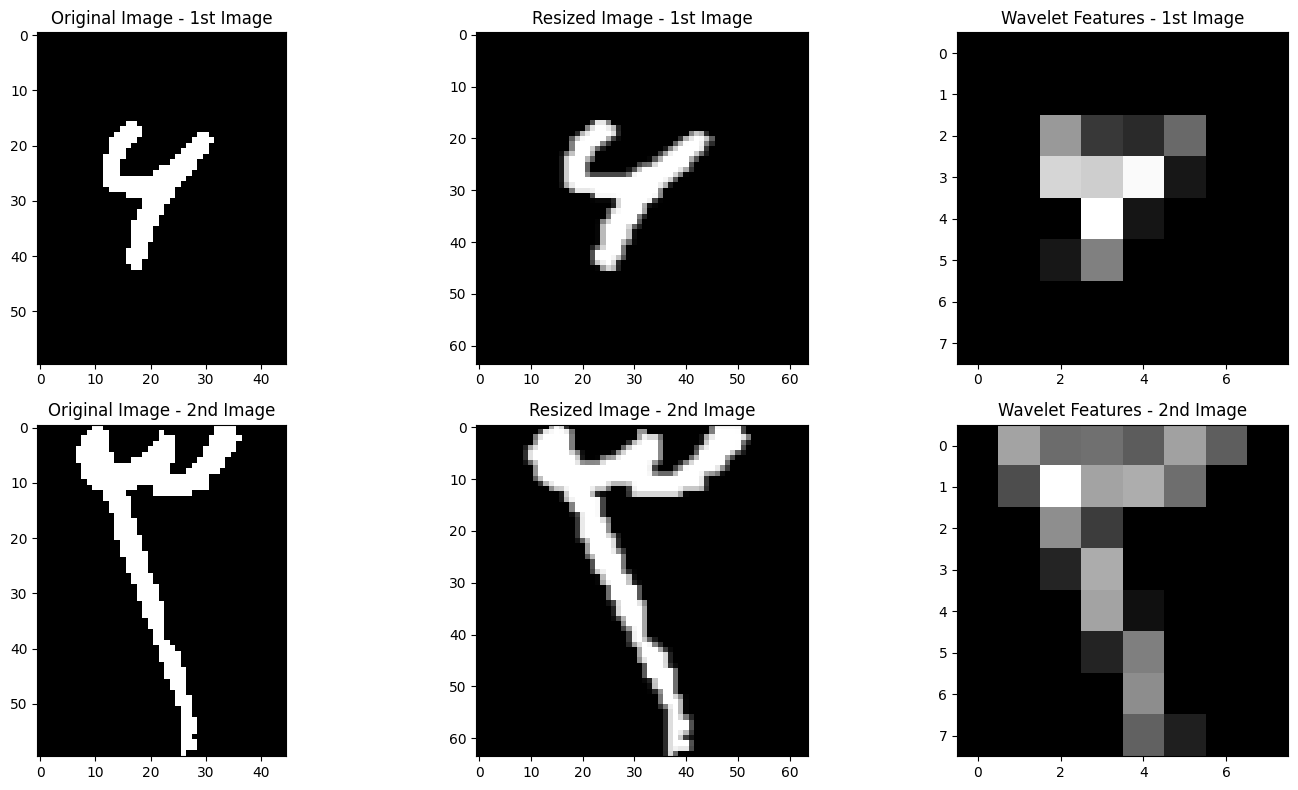

In [16]:
# Plot original images and wavelet features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# Reshape the wavelet features back to 8x8 images
reshaped_wavelet_features_1st = wavelet_features_train[0].reshape((8, 8))
reshaped_wavelet_features_2nd = np.concatenate((wavelet_features_train, wavelet_features_test), axis=0)[max_width_index].reshape((8, 8))
# Plot original images
axes[0, 0].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[0], cmap='gray')
axes[0, 0].set_title('Original Image - 1st Image')

axes[1, 0].imshow(np.concatenate((matrix_3d_train, matrix_3d_test), axis=0)[max_width_index], cmap='gray')
axes[1, 0].set_title('Original Image - 2nd Image')

# Plot wavelet features for the first image
axes[0, 1].imshow(resized_images_train[0], cmap='gray')
axes[0, 1].set_title('Resized Image - 1st Image')

axes[0, 2].imshow(reshaped_wavelet_features_1st, cmap='gray', interpolation='nearest')
axes[0, 2].set_title('Wavelet Features - 1st Image')

# Plot wavelet features for the second image
axes[1, 1].imshow(np.concatenate((resized_images_train, resized_images_test), axis=0)[max_width_index], cmap='gray')
axes[1, 1].set_title('Resized Image - 2nd Image')

axes[1, 2].imshow(reshaped_wavelet_features_2nd, cmap='gray', interpolation='nearest')
axes[1, 2].set_title('Wavelet Features - 2nd Image')

plt.tight_layout()
plt.show()

In [17]:
#Check correctness of dimension of train and test features
print(horizontal_histograms_train.shape)
print(vertical_histograms_train.shape)
print(horizontal_histograms_test.shape)
print(vertical_histograms_test.shape)
print(np.array(zoning_feature_vectors_train).shape)
print(np.array(zoning_feature_vectors_test).shape)
print(wavelet_features_train.shape)
print(wavelet_features_test.shape)
#normalize data
from sklearn.preprocessing import MinMaxScaler
# Assuming you have imported the necessary libraries and have your data loaded in the variables mentioned

# Normalizing ndarrays
scaler = MinMaxScaler()

horizontal_histograms_train = scaler.fit_transform(horizontal_histograms_train)
vertical_histograms_train = scaler.fit_transform(vertical_histograms_train)

horizontal_histograms_test  = scaler.fit_transform(horizontal_histograms_test)
vertical_histograms_test = scaler.fit_transform(vertical_histograms_test)

wavelet_features_train = scaler.fit_transform(wavelet_features_train)
wavelet_features_test = scaler.fit_transform(wavelet_features_test)

# Normalizing lists
zoning_feature_vectors_train = [scaler.fit_transform(np.array(vec).reshape(-1, 1)) for vec in zoning_feature_vectors_train]
zoning_feature_vectors_test = [scaler.fit_transform(np.array(vec).reshape(-1, 1)) for vec in zoning_feature_vectors_test]

(3000, 45)
(3000, 60)
(1000, 45)
(1000, 60)
(3000, 25)
(1000, 25)
(3000, 64)
(1000, 64)


In [18]:
class NearestMeanClassifier:
    def __init__(self):
        self.class_means = None

    def fit(self, X, y):
        unique_classes = np.unique(y)
        self.class_means = {}

        for class_label in unique_classes:
            class_instances = X[y == class_label]
            class_mean = np.mean(class_instances, axis=0)
            self.class_means[class_label] = class_mean

    def predict(self, X):
        if self.class_means is None:
            raise RuntimeError("The classifier has not been trained. Call fit() first.")

        predictions = []
        for instance in X:
            nearest_class = min(self.class_means.keys(), key=lambda x: np.linalg.norm(instance - self.class_means[x]))
            predictions.append(nearest_class)

        return np.array(predictions)

# Example usage:
# Assuming X_train, y_train, X_test are your training features, training labels, and test features
# X_train and X_test should be NumPy arrays

def NMC(FTr, LTr, FTe, LTe, str):
# Create and train the classifier
    classifier = NearestMeanClassifier()
    classifier.fit(FTr, LTr)
# Make predictions on the test set
    predictions = classifier.predict(FTe)
# Evaluate the accuracy or other metrics
    accuracy = np.mean(predictions == LTe)
    print(f"Accuracy By Nearest Mean Classifier with {str}: {accuracy}")

NMC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature')
NMC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature')
NMC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test), test_labels_subset, 'Zoning Feature')
NMC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature')


Accuracy By Nearest Mean Classifier with Horizontal Histograms Feature: 0.369
Accuracy By Nearest Mean Classifier with Vertical Histograms Feature: 0.511
Accuracy By Nearest Mean Classifier with Zoning Feature: 0.676
Accuracy By Nearest Mean Classifier with Wavelet Feature: 0.72


In [19]:
from collections import Counter

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

def KNNC(FTr, LTr, FTe, LTe, str, k=3):
    # Create KNN classifier
    knn = KNN(k)
    knn.fit(FTr, LTr)

    # Make predictions
    predictions = knn.predict(FTe)
    # Evaluate the accuracy or other metrics
    accuracy = np.mean(predictions == LTe)
    print(f"Accuracy By {k} Nearest Neighbor Classifier with {str}: {accuracy}")


KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature', 1)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature', 1)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test), test_labels_subset, 'Zoning Feature', 1)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature', 1)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature', 5)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature', 5)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test), test_labels_subset, 'Zoning Feature', 5)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature', 5)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature', 9)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature', 9)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test), test_labels_subset, 'Zoning Feature', 9)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature', 9)


Accuracy By 1 Nearest Neighbor Classifier with Horizontal Histograms Feature: 0.495
Accuracy By 1 Nearest Neighbor Classifier with Vertical Histograms Feature: 0.577
Accuracy By 1 Nearest Neighbor Classifier with Zoning Feature: 0.805
Accuracy By 1 Nearest Neighbor Classifier with Wavelet Feature: 0.878
Accuracy By 5 Nearest Neighbor Classifier with Horizontal Histograms Feature: 0.523
Accuracy By 5 Nearest Neighbor Classifier with Vertical Histograms Feature: 0.616
Accuracy By 5 Nearest Neighbor Classifier with Zoning Feature: 0.813
Accuracy By 5 Nearest Neighbor Classifier with Wavelet Feature: 0.897
Accuracy By 9 Nearest Neighbor Classifier with Horizontal Histograms Feature: 0.532
Accuracy By 9 Nearest Neighbor Classifier with Vertical Histograms Feature: 0.625
Accuracy By 9 Nearest Neighbor Classifier with Zoning Feature: 0.827
Accuracy By 9 Nearest Neighbor Classifier with Wavelet Feature: 0.888


In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
def GBC(FTr, LTr, FTe, LTe, str):
    # Create a Gaussian Naive Bayes classifier
    model = GaussianNB()
    # Train the model on the training set
    model.fit(FTr, LTr)
    # Make predictions on the testing set
    y_pred = model.predict(FTe)
    # Evaluate the performance of the classifier
    accuracy = metrics.accuracy_score(LTe, y_pred)
    print(f"Accuracy by Bayes with {str}: {accuracy}")

GBC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature')
GBC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature')
GBC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test).reshape(len(zoning_feature_vectors_test), -1), test_labels_subset, 'Zoning Feature')
GBC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature')


Accuracy by Bayes with Horizontal Histograms Feature: 0.162
Accuracy by Bayes with Vertical Histograms Feature: 0.205
Accuracy by Bayes with Zoning Feature: 0.499
Accuracy by Bayes with Wavelet Feature: 0.485


In [21]:
from scipy.stats import multivariate_normal

class ParzenWindowClassifier:
    def __init__(self, h=1.0):
        self.h = h  # Bandwidth parameter

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.classes = np.unique(y_train)

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)

    def _predict(self, x):
        likelihoods = []

        for c in self.classes:
            class_indices = np.where(self.y_train == c)[0]
            class_data = self.X_train[class_indices]

            # Calculate the Parzen window estimate for the class
            likelihood = np.sum(self._parzen_window(x, class_data)) / len(class_data)
            likelihoods.append(likelihood)

        # Return the class with the highest likelihood
        predicted_class = self.classes[np.argmax(likelihoods)]
        return predicted_class

    def _parzen_window(self, x, data):
        # Use a multivariate normal distribution as the window function
        window_function = multivariate_normal(mean=np.mean(data, axis=0), cov=np.eye(data.shape[1]) * self.h**2)
        return window_function.pdf(x)

def PWC(FTr, LTr, FTe, LTe, str, h = 1.0):
    # Create Parzen Window classifier
    parzen_classifier = ParzenWindowClassifier(h)
    parzen_classifier.fit(FTr, LTr)

    # Make predictions
    y_pred = parzen_classifier.predict(FTe)
    # Evaluate the performance of the classifier
    accuracy = metrics.accuracy_score(LTe, y_pred)
    print(f"Accuracy by Parzen Window Classifier(h = {h}) with {str}: {accuracy}")


PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature', 0.1)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature', 0.1)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test).reshape(len(zoning_feature_vectors_test), -1), test_labels_subset, 'Zoning Feature', 0.1)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature', 0.1)


PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test, test_labels_subset, 'Horizontal Histograms Feature', 0.35)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test, test_labels_subset, 'Vertical Histograms Feature', 0.35)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test).reshape(len(zoning_feature_vectors_test), -1), test_labels_subset, 'Zoning Feature', 0.35)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test, test_labels_subset, 'Wavelet Feature', 0.35)



Accuracy by Parzen Window Classifier(h = 0.1) with Horizontal Histograms Feature: 0.369
Accuracy by Parzen Window Classifier(h = 0.1) with Vertical Histograms Feature: 0.503
Accuracy by Parzen Window Classifier(h = 0.1) with Zoning Feature: 0.676
Accuracy by Parzen Window Classifier(h = 0.1) with Wavelet Feature: 0.721
Accuracy by Parzen Window Classifier(h = 0.35) with Horizontal Histograms Feature: 0.368
Accuracy by Parzen Window Classifier(h = 0.35) with Vertical Histograms Feature: 0.487
Accuracy by Parzen Window Classifier(h = 0.35) with Zoning Feature: 0.675
Accuracy by Parzen Window Classifier(h = 0.35) with Wavelet Feature: 0.718


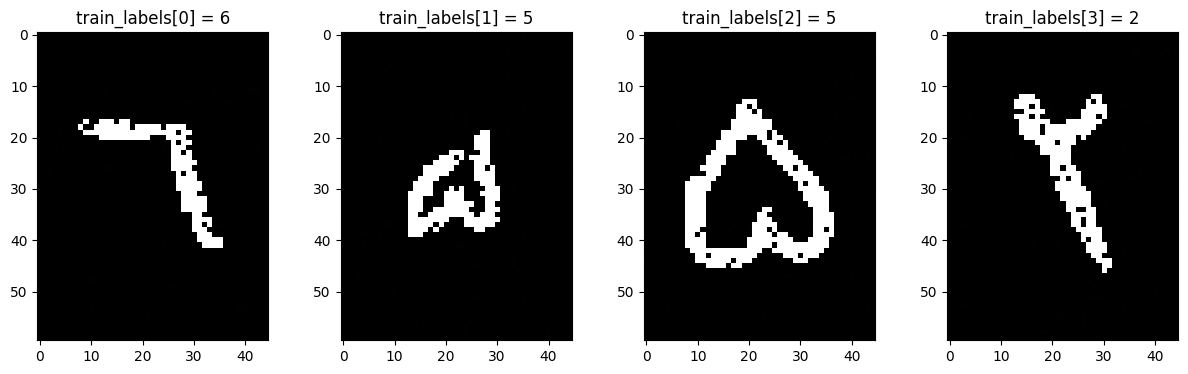

In [22]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    """
    Add salt and pepper noise to an image.

    Parameters:
    - image: 2D NumPy array (image matrix)
    - salt_prob: Probability of adding salt noise
    - pepper_prob: Probability of adding pepper noise

    Returns:
    - Noisy image
    """
    noisy_image = np.copy(image)

    # Add salt noise
    salt_coords = np.random.rand(*image.shape) < salt_prob
    noisy_image[salt_coords] = 1.0

    # Add pepper noise
    pepper_coords = np.random.rand(*image.shape) < pepper_prob
    noisy_image[pepper_coords] = 0.0

    return noisy_image

# Parameters for salt and pepper noise
salt_prob = 0.05  # Adjust as needed
pepper_prob = 0.05  # Adjust as needed

# Add salt and pepper noise to each image
SP1_noisy_matrix = np.array([add_salt_and_pepper_noise(image, salt_prob, pepper_prob) for image in matrix_3d_test])
# Plot the first 4 images of matrix_3d
fig = plt.figure(figsize=(15, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(test_labels_subset[i]))
    plt.imshow(SP1_noisy_matrix[i], cmap='gray')

plt.show()


In [23]:
horizontal_histograms_test_SP = np.sum(SP1_noisy_matrix, axis=1)
vertical_histograms_test_SP = np.sum(SP1_noisy_matrix, axis=2)
# Resize the images
resized_images_test_SP = resize_images(SP1_noisy_matrix)
# Extract wavelet features for each image
wavelet_features_test_SP = np.array([extract_wavelet_features(img) for img in resized_images_test_SP])
zoning_feature_vectors_test_SP = zoning(SP1_noisy_matrix)
# Reshape zoning feature vectors to 5x5 matrices
zoning_matrices_test_SP = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning_feature_vectors_test_SP]

In [24]:

NMC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)')
NMC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)')
NMC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_SP), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)')
NMC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)')


Accuracy By Nearest Mean Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.335
Accuracy By Nearest Mean Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 0.223
Accuracy By Nearest Mean Classifier with Zoning Feature(Salt and Pepper Noise): 0.108
Accuracy By Nearest Mean Classifier with Wavelet Feature(Salt and Pepper Noise): 0.696


In [25]:
KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)', 1)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)', 1)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_SP), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)', 1)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)', 1)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)', 5)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)', 5)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_SP), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)', 5)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)', 5)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)', 9)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)', 9)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_SP), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)', 9)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)', 9)

GBC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)')
GBC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)')
GBC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_SP).reshape(len(zoning_feature_vectors_test_SP), -1), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)')
GBC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)')

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)', 0.1)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)', 0.1)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_SP).reshape(len(zoning_feature_vectors_test_SP), -1), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)', 0.1)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)', 0.1)

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_SP, test_labels_subset, 'Horizontal Histograms Feature(Salt and Pepper Noise)', 0.35)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_SP, test_labels_subset, 'Vertical Histograms Feature(Salt and Pepper Noise)', 0.35)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_SP).reshape(len(zoning_feature_vectors_test_SP), -1), test_labels_subset, 'Zoning Feature(Salt and Pepper Noise)', 0.35)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_SP, test_labels_subset, 'Wavelet Feature(Salt and Pepper Noise)', 0.35)



Accuracy By 1 Nearest Neighbor Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.109
Accuracy By 1 Nearest Neighbor Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 0.106
Accuracy By 1 Nearest Neighbor Classifier with Zoning Feature(Salt and Pepper Noise): 0.105
Accuracy By 1 Nearest Neighbor Classifier with Wavelet Feature(Salt and Pepper Noise): 0.259
Accuracy By 5 Nearest Neighbor Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.159
Accuracy By 5 Nearest Neighbor Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 0.141
Accuracy By 5 Nearest Neighbor Classifier with Zoning Feature(Salt and Pepper Noise): 0.108
Accuracy By 5 Nearest Neighbor Classifier with Wavelet Feature(Salt and Pepper Noise): 0.512
Accuracy By 9 Nearest Neighbor Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.207
Accuracy By 9 Nearest Neighbor Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 

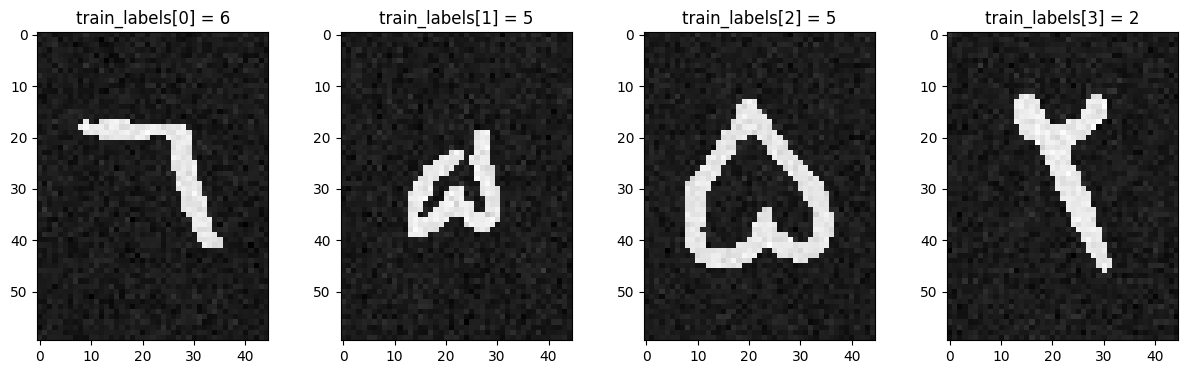

In [26]:
mean = 0
std_dev = 10  # You can adjust this value based on the desired amount of noise

# Create a new matrix to store the noisy images
Gnoisy_matrix_3d = np.empty_like(matrix_3d_test)

# Iterate over each image in the 3D array and add Gaussian noise
for i in range(matrix_3d_test.shape[0]):
    noise = np.random.normal(mean, std_dev, size=matrix_3d_test[i].shape)
    Gnoisy_matrix_3d[i] = matrix_3d_test[i] + noise

# Now, noisy_matrix_3d contains the original images with added Gaussian noise
# Plot the first 4 images of matrix_3d
fig = plt.figure(figsize=(15, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(test_labels_subset[i]))
    plt.imshow(Gnoisy_matrix_3d[i], cmap='gray')

plt.show()

In [27]:
horizontal_histograms_test_G = np.sum(Gnoisy_matrix_3d, axis=1)
vertical_histograms_test_G = np.sum(Gnoisy_matrix_3d, axis=2)
# Resize the images
resized_images_test_G = resize_images(Gnoisy_matrix_3d)
# Extract wavelet features for each image
wavelet_features_test_G = np.array([extract_wavelet_features(img) for img in resized_images_test_G])
zoning_feature_vectors_test_G = zoning(Gnoisy_matrix_3d)
# Reshape zoning feature vectors to 5x5 matrices
zoning_matrices_test_G = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning_feature_vectors_test_G]

In [28]:
NMC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)')
NMC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)')
NMC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_G), test_labels_subset, 'Zoning Feature(Gaussian)')
NMC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)')

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)', 1)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)', 1)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_G), test_labels_subset, 'Zoning Feature(Gaussian)', 1)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)', 1)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)', 5)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)', 5)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_G), test_labels_subset, 'Zoning Feature(Gaussian)', 5)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)', 5)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)', 9)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)', 9)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_G), test_labels_subset, 'Zoning Feature(Gaussian)', 9)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)', 9)

GBC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)')
GBC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)')
GBC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_G).reshape(len(zoning_feature_vectors_test_G), -1), test_labels_subset, 'Zoning Feature(Gaussian)')
GBC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)')

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)', 0.1)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)', 0.1)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_G).reshape(len(zoning_feature_vectors_test_G), -1), test_labels_subset, 'Zoning Feature(Gaussian)', 0.1)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)', 0.1)

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_G, test_labels_subset, 'Horizontal Histograms Feature(Gaussian)', 0.35)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_G, test_labels_subset, 'Vertical Histograms Feature(Gaussian)', 0.35)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_G).reshape(len(zoning_feature_vectors_test_G), -1), test_labels_subset, 'Zoning Feature(Gaussian)', 0.35)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_G, test_labels_subset, 'Wavelet Feature(Gaussian)', 0.35)


Accuracy By Nearest Mean Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.341
Accuracy By Nearest Mean Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 0.225
Accuracy By Nearest Mean Classifier with Zoning Feature(Salt and Pepper Noise): 0.108
Accuracy By Nearest Mean Classifier with Wavelet Feature(Salt and Pepper Noise): 0.7
Accuracy By 1 Nearest Neighbor Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.108
Accuracy By 1 Nearest Neighbor Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 0.106
Accuracy By 1 Nearest Neighbor Classifier with Zoning Feature(Salt and Pepper Noise): 0.105
Accuracy By 1 Nearest Neighbor Classifier with Wavelet Feature(Salt and Pepper Noise): 0.26
Accuracy By 5 Nearest Neighbor Classifier with Horizontal Histograms Feature(Salt and Pepper Noise): 0.156
Accuracy By 5 Nearest Neighbor Classifier with Vertical Histograms Feature(Salt and Pepper Noise): 0.141
Accuracy By 5 Nearest

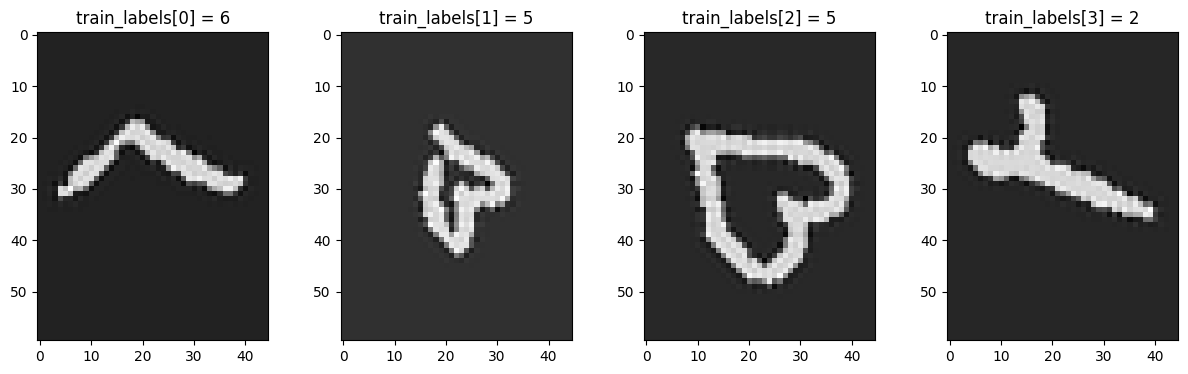

In [32]:
from scipy.ndimage import rotate

# Specify the rotation angle in degrees
rotation_angle = 45  # You can change this value based on your requirement

# Create an empty array to store the rotated images
rotated_images = np.empty_like(matrix_3d_test)

# Iterate over each image and rotate it
for i in range(matrix_3d_test.shape[0]):
    rotated_images[i] = rotate(matrix_3d_test[i], rotation_angle, reshape=False)

# Now, rotated_images contains the rotated versions of each image in matrix_3d_test
# Plot the first 4 images of matrix_3d
fig = plt.figure(figsize=(15, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(test_labels_subset[i]))
    plt.imshow(rotated_images[i], cmap='gray')

plt.show()

In [33]:
horizontal_histograms_test_R = np.sum(rotated_images, axis=1)
vertical_histograms_test_R = np.sum(rotated_images, axis=2)
# Resize the images
resized_images_test_R = resize_images(rotated_images)
# Extract wavelet features for each image
wavelet_features_test_R = np.array([extract_wavelet_features(img) for img in resized_images_test_R])
zoning_feature_vectors_test_R = zoning(rotated_images)
# Reshape zoning feature vectors to 5x5 matrices
zoning_matrices_test_R = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning_feature_vectors_test_R]

In [46]:
NMC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)')
NMC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)')
NMC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R), test_labels_subset, 'Zoning Feature(rotated images by angle 45)')
NMC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)')

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)', 1)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)', 1)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R), test_labels_subset, 'Zoning Feature(rotated images by angle 45)', 1)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)', 1)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)', 5)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)', 5)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R), test_labels_subset, 'Zoning Feature(rotated images by angle 45)', 5)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)', 5)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)', 9)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)', 9)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R), test_labels_subset, 'Zoning Feature(rotated images by angle 45)', 9)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)', 9)

GBC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)')
GBC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)')
GBC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_R).reshape(len(zoning_feature_vectors_test_R), -1), test_labels_subset, 'Zoning Feature(rotated images by angle 45)')
GBC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)')

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)', 0.1)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)', 0.1)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_R).reshape(len(zoning_feature_vectors_test_R), -1), test_labels_subset, 'Zoning Feature(rotated images by angle 45)', 0.1)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)', 0.1)

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 45)', 0.35)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 45)', 0.35)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_R).reshape(len(zoning_feature_vectors_test_R), -1), test_labels_subset, 'Zoning Feature(rotated images by angle 45)', 0.35)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_R, test_labels_subset, 'Wavelet Feature(rotated images by angle 45)', 0.35)


Accuracy By Nearest Mean Classifier with Horizontal Histograms Feature(rotated images by angle 45): 0.166
Accuracy By Nearest Mean Classifier with Vertical Histograms Feature(rotated images by angle 45): 0.116
Accuracy By Nearest Mean Classifier with Zoning Feature(rotated images by angle 45): 0.108
Accuracy By Nearest Mean Classifier with Wavelet Feature(rotated images by angle 45): 0.253
Accuracy By 1 Nearest Neighbor Classifier with Horizontal Histograms Feature(rotated images by angle 45): 0.075
Accuracy By 1 Nearest Neighbor Classifier with Vertical Histograms Feature(rotated images by angle 45): 0.097
Accuracy By 1 Nearest Neighbor Classifier with Zoning Feature(rotated images by angle 45): 0.105
Accuracy By 1 Nearest Neighbor Classifier with Wavelet Feature(rotated images by angle 45): 0.098
Accuracy By 5 Nearest Neighbor Classifier with Horizontal Histograms Feature(rotated images by angle 45): 0.058
Accuracy By 5 Nearest Neighbor Classifier with Vertical Histograms Feature(rot

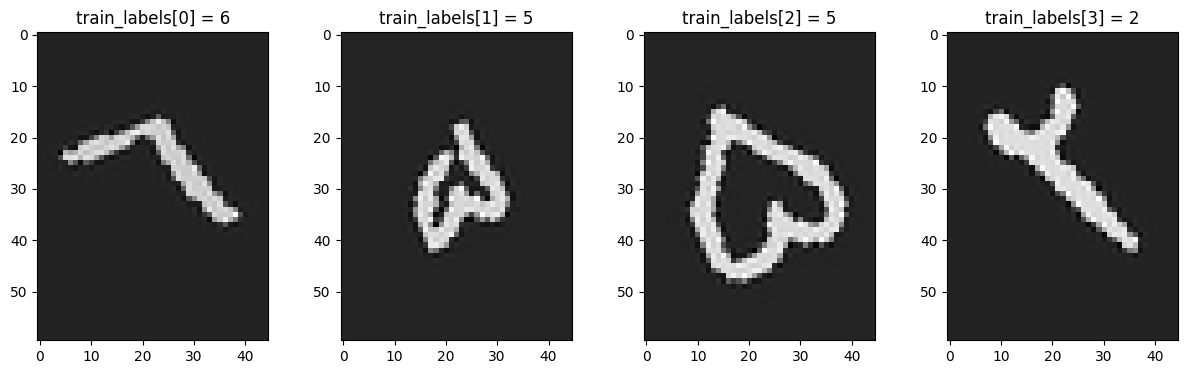

Accuracy By Nearest Mean Classifier with Horizontal Histograms Feature(rotated images by angle 22): 0.182
Accuracy By Nearest Mean Classifier with Vertical Histograms Feature(rotated images by angle 22): 0.183
Accuracy By Nearest Mean Classifier with Zoning Feature(rotated images by angle 22): 0.108
Accuracy By Nearest Mean Classifier with Wavelet Feature(rotated images by angle 22): 0.48
Accuracy By 1 Nearest Neighbor Classifier with Horizontal Histograms Feature(rotated images by angle 22): 0.108
Accuracy By 1 Nearest Neighbor Classifier with Vertical Histograms Feature(rotated images by angle 22): 0.101
Accuracy By 1 Nearest Neighbor Classifier with Zoning Feature(rotated images by angle 22): 0.105
Accuracy By 3 Nearest Neighbor Classifier with Wavelet Feature(rotated images by angle 22): 0.207
Accuracy By 5 Nearest Neighbor Classifier with Horizontal Histograms Feature(rotated images by angle 22): 0.095
Accuracy By 5 Nearest Neighbor Classifier with Vertical Histograms Feature(rota

In [48]:
from scipy.ndimage import rotate

# Specify the rotation angle in degrees
rotation_angle = 22  # You can change this value based on your requirement

# Create an empty array to store the rotated images
rotated_images = np.empty_like(matrix_3d_test)

# Iterate over each image and rotate it
for i in range(matrix_3d_test.shape[0]):
    rotated_images[i] = rotate(matrix_3d_test[i], rotation_angle, reshape=False)

# Now, rotated_images contains the rotated versions of each image in matrix_3d_test
# Plot the first 4 images of matrix_3d
fig = plt.figure(figsize=(15, 4))
for i in range(4):
    fig.add_subplot(1, 4, i + 1)
    plt.title('train_labels[' + str(i) + '] = ' + str(test_labels_subset[i]))
    plt.imshow(rotated_images[i], cmap='gray')

plt.show()


horizontal_histograms_test_R1 = np.sum(rotated_images, axis=1)
vertical_histograms_test_R1 = np.sum(rotated_images, axis=2)
# Resize the images
resized_images_test_R1 = resize_images(rotated_images)
# Extract wavelet features for each image
wavelet_features_test_R1 = np.array([extract_wavelet_features(img) for img in resized_images_test_R1])
zoning_feature_vectors_test_R1 = zoning(rotated_images)
# Reshape zoning feature vectors to 5x5 matrices
zoning_matrices_test_R1 = [np.array(feature_vector).reshape(5, 5) for feature_vector in zoning_feature_vectors_test_R1]

NMC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)')
NMC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)')
NMC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)')
NMC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)')

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)', 1)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)', 1)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)', 1)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)')

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)', 5)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)', 5)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)', 5)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)', 5)

KNNC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)', 9)
KNNC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)', 9)
KNNC(np.array(zoning_feature_vectors_train), train_labels_subset, np.array(zoning_feature_vectors_test_R1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)', 9)
KNNC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)', 9)

GBC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)')
GBC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)')
GBC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_R1).reshape(len(zoning_feature_vectors_test_R1), -1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)')
GBC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)')

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)', 0.1)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)', 0.1)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_R1).reshape(len(zoning_feature_vectors_test_R1), -1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)', 0.1)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)', 0.1)

PWC(horizontal_histograms_train, train_labels_subset, horizontal_histograms_test_R1, test_labels_subset, 'Horizontal Histograms Feature(rotated images by angle 22)', 0.35)
PWC(vertical_histograms_train, train_labels_subset, vertical_histograms_test_R1, test_labels_subset, 'Vertical Histograms Feature(rotated images by angle 22)', 0.35)
PWC(np.array(zoning_feature_vectors_train).reshape(len(zoning_feature_vectors_train), -1), train_labels_subset, np.array(zoning_feature_vectors_test_R1).reshape(len(zoning_feature_vectors_test_R1), -1), test_labels_subset, 'Zoning Feature(rotated images by angle 22)', 0.35)
PWC(wavelet_features_train, train_labels_subset, wavelet_features_test_R1, test_labels_subset, 'Wavelet Feature(rotated images by angle 22)', 0.35)
